In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
import requests
import base64
import matplotlib.pyplot as plt
import numpy as np
from elasticsearch import Elasticsearch
from urllib import parse
import pandas as pd
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import logging
logging.basicConfig(level=logging.CRITICAL)

from code_utils.elastic import get_from_es,get_data_from_elastic,plot_graph,interfaces_evaluation
from code_utils.utils import get_year_ipbes,get_year_ipcc,aplatir

In [2]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "must_not": [
        {
          "term": {
            "predict_teds.label": "ipcc_science"
          }
        },
        {
          "term": {
            "predict_teds.label": "ipcc_adaptation"
          }
        },
        {
          "term": {
            "predict_teds.label": "ipcc_mitigation"
          }
        }
      ],
      "filter": {
        "exists": {
          "field": "topics"
        }
      }
    }
  },
  "aggs": {
    "predicted_labels": {
      "terms": {
        "field": "predict_teds.label.keyword",
        "size": 10000000
      }
    }
  }
}
get_from_es(body,'scanr-publications')

{'error': {'root_cause': [{'type': 'security_exception',
    'reason': 'unable to authenticate user [None] for REST request [/scanr-publications-20241114/_search]',
    'header': {'WWW-Authenticate': ['Basic realm="security" charset="UTF-8"',
      'ApiKey']}}],
  'type': 'security_exception',
  'reason': 'unable to authenticate user [None] for REST request [/scanr-publications-20241114/_search]',
  'header': {'WWW-Authenticate': ['Basic realm="security" charset="UTF-8"',
    'ApiKey']}},
 'status': 401}

In [14]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "must": [
        {
          "exists": {
            "field": "topics"
          }
        }
      ]
    }
  },
  "aggs": {
    "predicted_labels": {
      "terms": {
        "field": "predict_teds.label.keyword",
        "size": 10000000
      }
    }
  }
}
get_from_es(body,'scanr-publications')

{'took': 4,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1451506, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'predicted_labels': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 'not_ipcc', 'doc_count': 1386002},
    {'key': 'ipcc', 'doc_count': 65504},
    {'key': 'ipcc_adaptation', 'doc_count': 43479},
    {'key': 'ipcc_science', 'doc_count': 15250},
    {'key': 'ipcc_mitigation', 'doc_count': 8819}]}}}

In [19]:
15250/1451506*100

1.0506329288339147

Avec topics

In [12]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "exists": {
      "field": "topics"
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')

data_counts={}
for x in data['aggregations']['years']['buckets']:
    if x['doc_count']>=500 and x['key']>=2013:
      data_counts[x['key']]=[]#x['doc_count']]
      if 'ipcc_science' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          data_counts[x['key']].append([bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_science'][0]) 
      else:
          data_counts[x['key']].append(0)
      if 'ipcc_adaptation' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          data_counts[x['key']].append([bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_adaptation'][0]) 
      else:
          data_counts[x['key']].append(0)
      if 'ipcc_mitigation' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:   
          data_counts[x['key']].append([bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_mitigation'][0]) 
      else:
          data_counts[x['key']].append(0)
data_counts={key: value for key, value in data_counts.items() if value!= [0, 0, 0]}


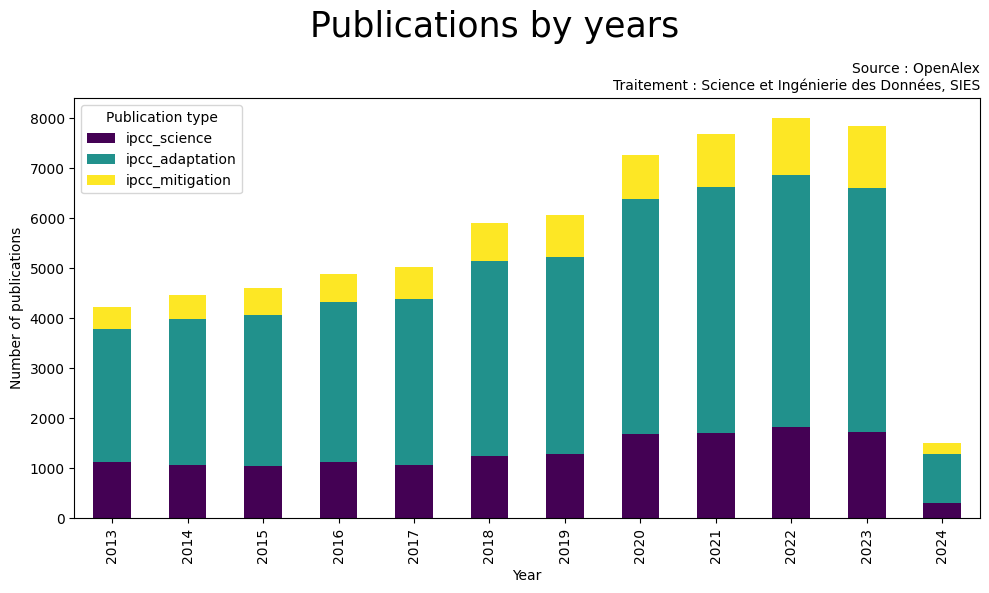

In [13]:
df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['ipcc_science', 'ipcc_adaptation', 'ipcc_mitigation'])
df = df.sort_index()
ax = df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
ax.set_xlabel('Year')
ax.set_ylabel('Number of publications')
ax.legend(title='Publication type')

plt.suptitle("Publications by years", size=25)
plt.title('Source : OpenAlex\nTraitement : Science et Ingénierie des Données, SIES', size=10, loc='right')
plt.tight_layout()
plt.show()

In [15]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "exists": {
      "field": "topics"
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')

data_counts={}
for x in data['aggregations']['years']['buckets']:
    data_counts[x['key']]=[]
    if 'not_ipcc' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
        nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='not_ipcc'][0]
        data_counts[x['key']].append(round(nb*100/x['doc_count'],1)) 
    else:
        data_counts[x['key']].append(0)
    if 'ipcc' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
        nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc'][0]
        data_counts[x['key']].append(round(nb*100/x['doc_count'],1)) 
    else:
        data_counts[x['key']].append(0)
data_counts={key: value for key, value in data_counts.items() if value!= [0, 0] and value != [100,0]}


C:\Users\haallat\AppData\Local\Temp\ipykernel_7496\3147467221.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()], fontsize=15)


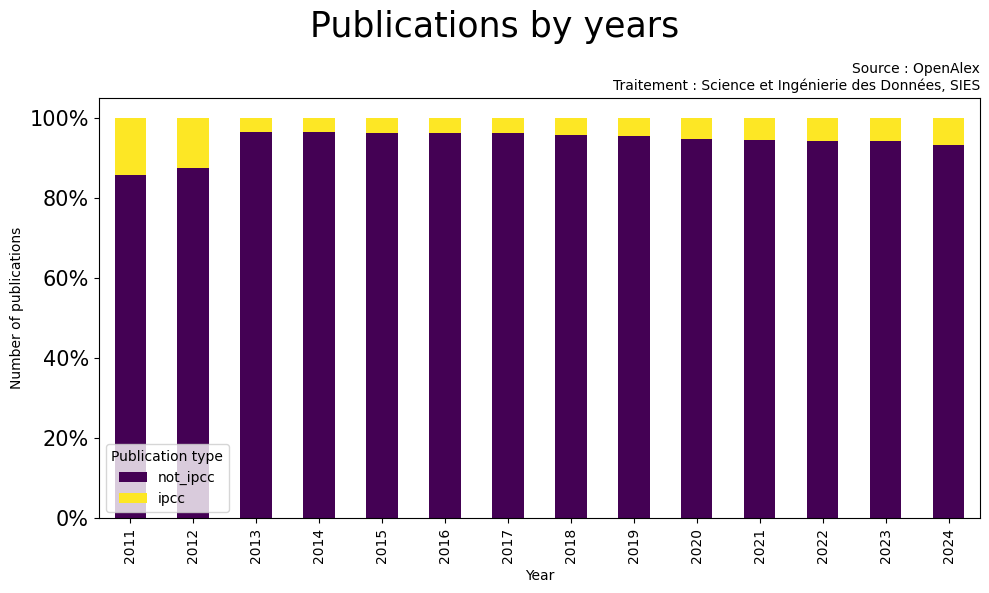

In [16]:
df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['not_ipcc', 'ipcc'])
df = df.sort_index()
ax = df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
ax.set_xlabel('Year')
ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()], fontsize=15)
ax.set_ylabel('Number of publications')
ax.legend(title='Publication type')

plt.suptitle("Publications by years", size=25)
plt.title('Source : OpenAlex\nTraitement : Science et Ingénierie des Données, SIES', size=10, loc='right')
plt.tight_layout()
plt.show()

C:\Users\haallat\AppData\Local\Temp\ipykernel_7496\551358447.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()], fontsize=12)


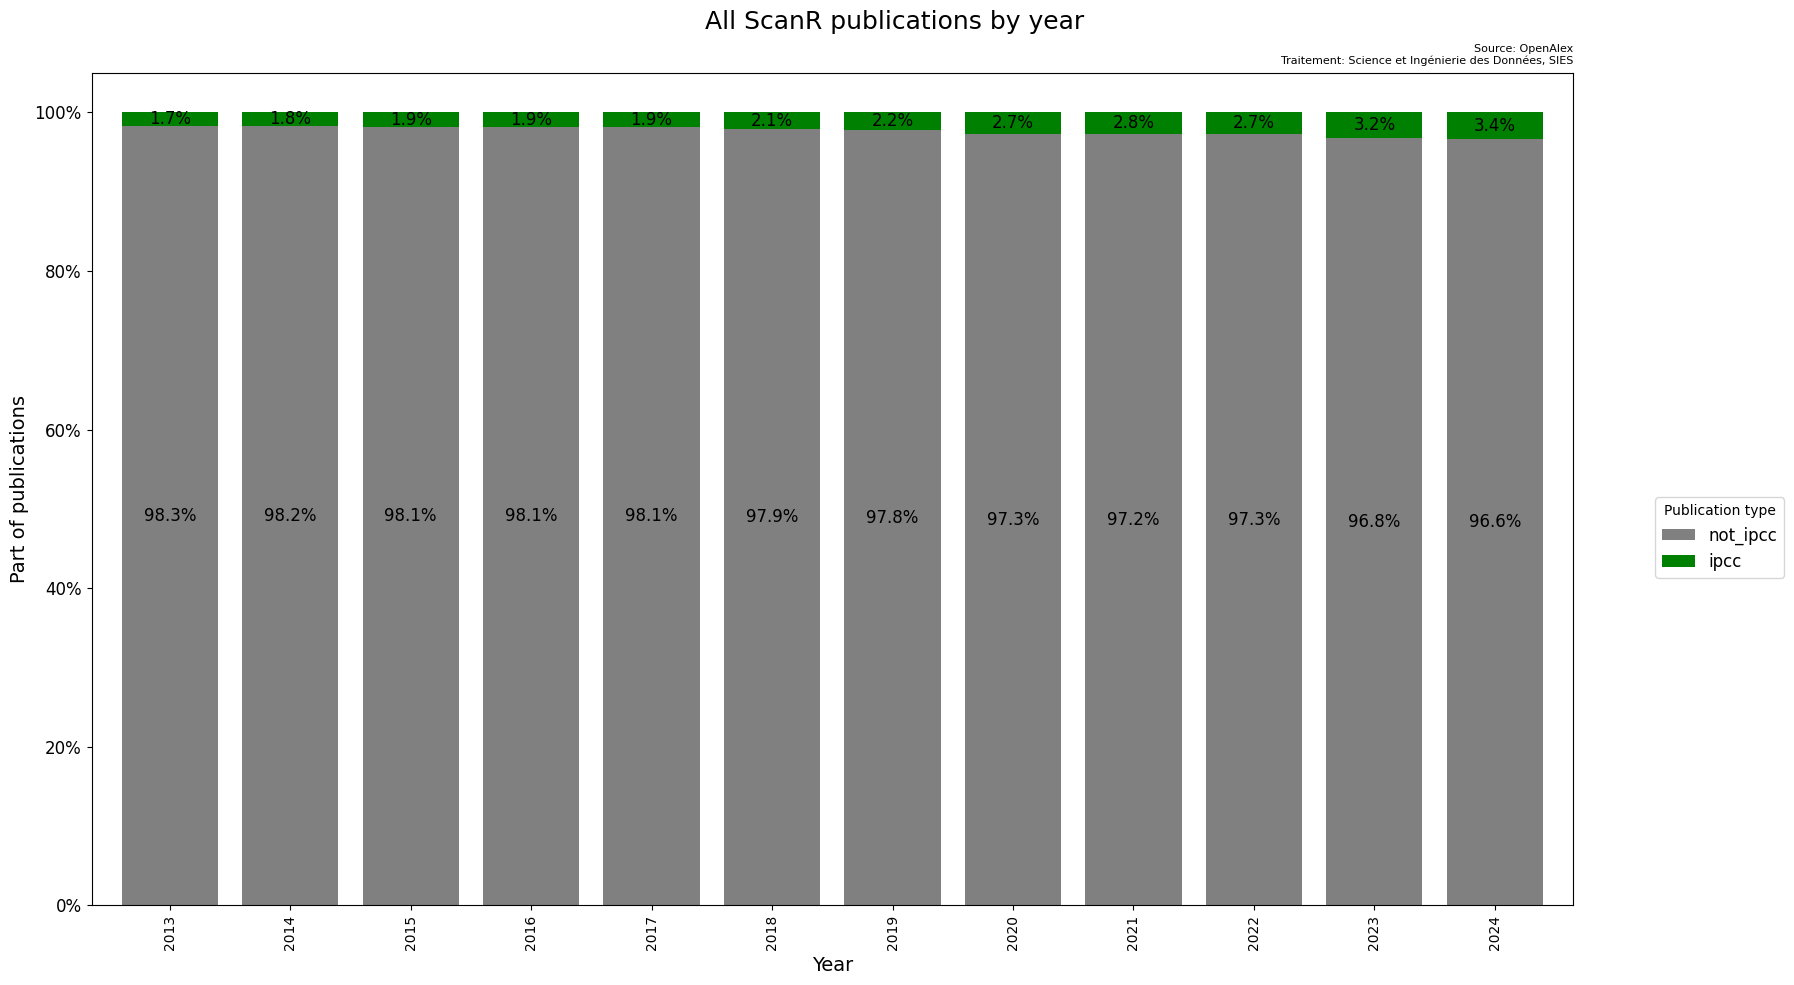

In [20]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "filter": {
       "exists": {
         "field": "year"
       }
      }
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')
data_counts={}
for x in data['aggregations']['years']['buckets']:
    if x['doc_count']>=500 and x['key']>=2013:
      data_counts[x['key']]=[]
      if 'not_ipcc' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='not_ipcc'][0]
          data_counts[x['key']].append(round(nb*100/x['doc_count'],1)) 
      else:
          data_counts[x['key']].append(0)
      if 'ipcc' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc'][0]
          data_counts[x['key']].append(round(nb*100/x['doc_count'],1)) 
      else:
          data_counts[x['key']].append(0)
data_counts={key: value for key, value in data_counts.items() if value!= [0, 0] and value != [100,0]}


df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['not_ipcc', 'ipcc'])
df = df.sort_index()

ax = df.head(50).plot(kind='bar', stacked=True, figsize=(18, 10), width=0.8, color=['gray', 'green'])

for i, (index, row) in enumerate(df.head(50).iterrows()): 
    ax.text(i, row['not_ipcc'] / 2, f'{row["not_ipcc"]}%', ha='center', va='center', color='black', size=12)
    ax.text(i, row['not_ipcc'] + row['ipcc'] / 2, f'{row["ipcc"]}%', ha='center', va='center', color='black', size=12)

ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Part of publications', fontsize=14)
ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()], fontsize=12)

ax.legend(title='Publication type', bbox_to_anchor=(1.05, 0.5), loc='upper left', fontsize=12)

plt.suptitle("All ScanR publications by year", size=18)
plt.title('Source: OpenAlex\nTraitement: Science et Ingénierie des Données, SIES', size=8, loc='right')

plt.tight_layout()
plt.show()

C:\Users\haallat\AppData\Local\Temp\ipykernel_7496\4257876934.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()], fontsize=12)


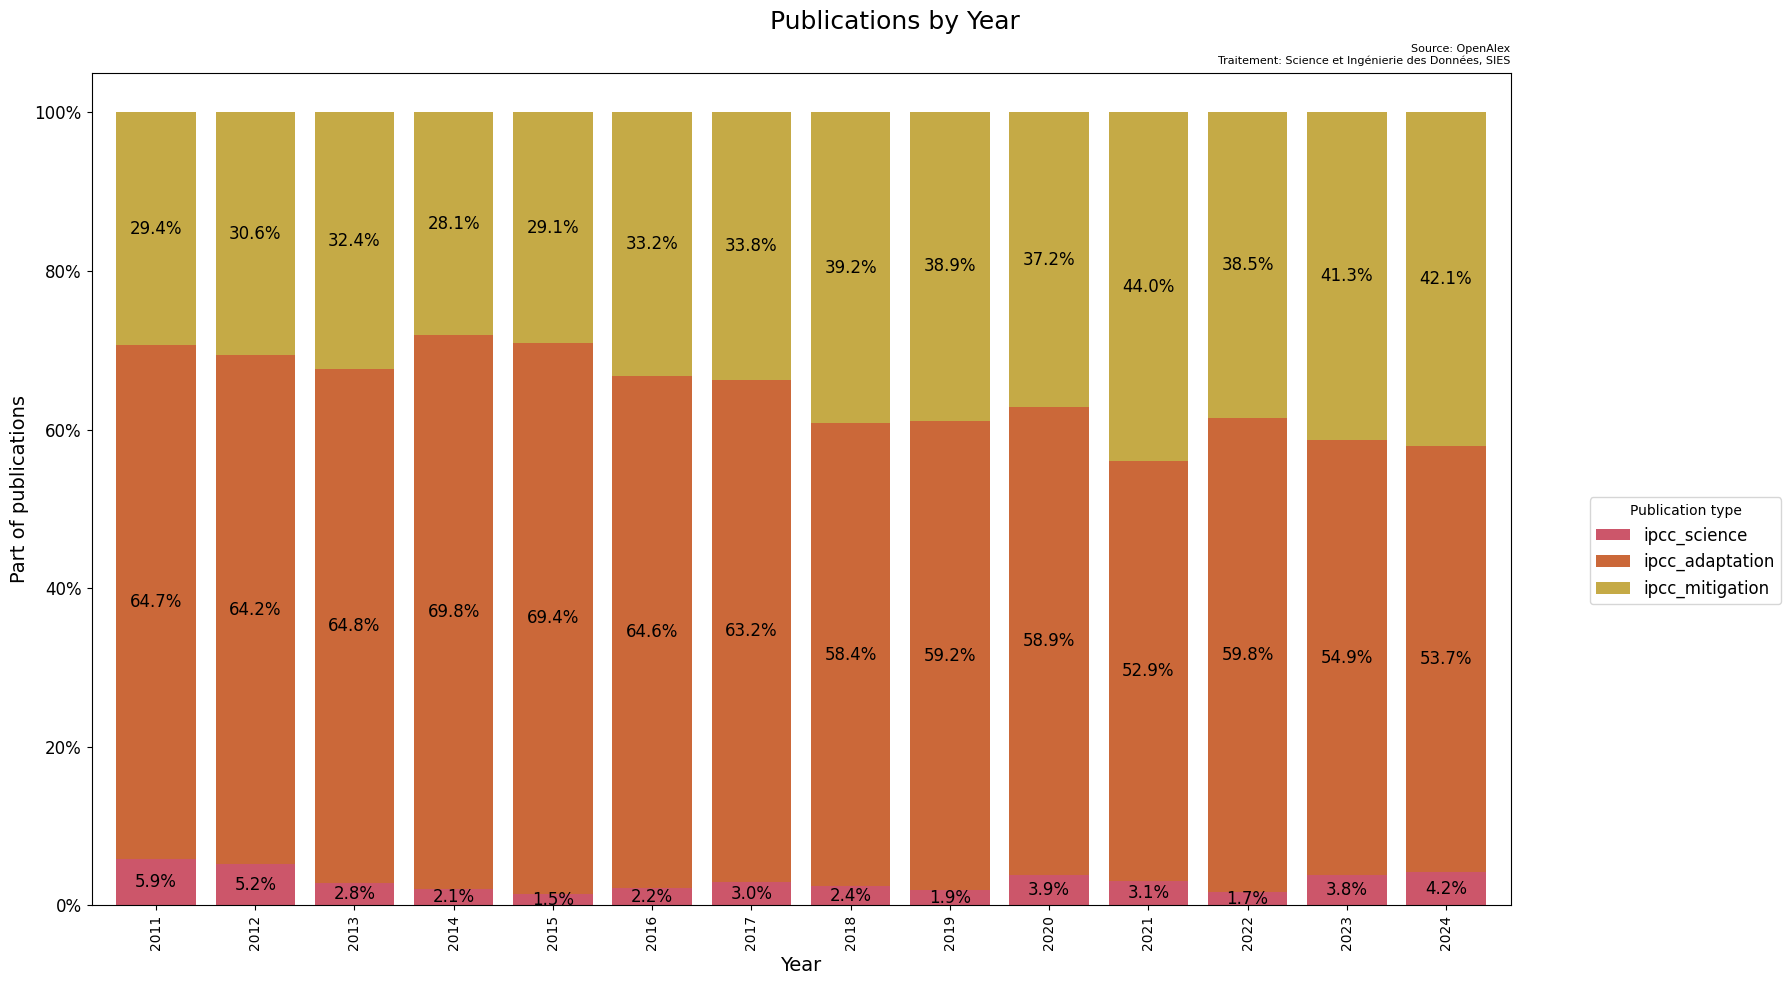

In [11]:
#sans les topics
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "must_not": {
       "exists": {
         "field": "topics"
       }
      }
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')
data_counts={}
for x in data['aggregations']['years']['buckets']:
    if x['doc_count']>=500 and x['key']>=2011:
      data_counts[x['key']]=[]
      tot=sum([i['doc_count'] for i in x['predicted_labels']['buckets'] if i['key'] in ['ipcc_science', 'ipcc_adaptation','ipcc_mitigation']])
      if 'ipcc_science' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_science'][0]
          data_counts[x['key']].append(round(nb*100/tot,1)) 
      else:
          data_counts[x['key']].append(0)
      if 'ipcc_adaptation' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_adaptation'][0]
          data_counts[x['key']].append(round(nb*100/tot,1)) 
      else:
          data_counts[x['key']].append(0)
      if 'ipcc_mitigation' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_mitigation'][0]
          data_counts[x['key']].append(round(nb*100/tot,1)) 
      else:
          data_counts[x['key']].append(0)
data_counts={key: value for key, value in data_counts.items() if value!= [0, 0, 0]}
df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['ipcc_science', 'ipcc_adaptation','ipcc_mitigation'])
df = df.sort_index()

list_colors=["#cc566a","#cb6839","#c5aa46","#747734","#62b055","#4bb2ac","#7377cc","#be5dae"]
ax = df.head(50).plot(kind='bar', stacked=True, figsize=(18, 10), width=0.8, color=list_colors)

for i, (index, row) in enumerate(df.head(50).iterrows()): 
    if row["ipcc_science"]!=0:
      ax.text(i, row['ipcc_science'] / 2, f'{row["ipcc_science"]}%', ha='center', va='center', color='black', size=12)
    if row["ipcc_adaptation"]!=0:
      ax.text(i, row['ipcc_science'] + row['ipcc_adaptation'] / 2, f'{row["ipcc_adaptation"]}%', ha='center', va='center', color='black', size=12)
    if row["ipcc_mitigation"]!=0:
      ax.text(i, row['ipcc_science'] + row['ipcc_adaptation'] + row['ipcc_mitigation']/ 2, f'{row["ipcc_mitigation"]}%', ha='center', va='center', color='black', size=12)

ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Part of publications', fontsize=14)
ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()], fontsize=12)

ax.legend(title='Publication type', bbox_to_anchor=(1.05, 0.5), loc='upper left', fontsize=12)

plt.suptitle("Publications by Year", size=18)
plt.title('Source: OpenAlex\nTraitement: Science et Ingénierie des Données, SIES', size=8, loc='right')

plt.tight_layout()
plt.show()

In [61]:
data

{'took': 5,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 4550895, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'years': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 2019,
     'doc_count': 184096,
     'predicted_labels': {'doc_count_error_upper_bound': 0,
      'sum_other_doc_count': 0,
      'buckets': [{'key': 'not_ipcc', 'doc_count': 183132},
       {'key': 'ipcc', 'doc_count': 964},
       {'key': 'ipcc_adaptation', 'doc_count': 439},
       {'key': 'ipcc_mitigation', 'doc_count': 289},
       {'key': 'ipcc_science', 'doc_count': 14}]}},
    {'key': 2018,
     'doc_count': 179926,
     'predicted_labels': {'doc_count_error_upper_bound': 0,
      'sum_other_doc_count': 0,
      'buckets': [{'key': 'not_ipcc', 'doc_count': 179092},
       {'key': 'ipcc', 'doc_count': 834},
       {'key': 'ipcc_adaptation', 'doc_count': 391},
       {'key': 

In [63]:
data['aggregations']['years']['buckets'][0]

{'key': 2022,
 'doc_count': 139716,
 'predicted_labels': {'doc_count_error_upper_bound': 0,
  'sum_other_doc_count': 0,
  'buckets': [{'key': 'not_ipcc', 'doc_count': 131942},
   {'key': 'ipcc', 'doc_count': 7774},
   {'key': 'ipcc_adaptation', 'doc_count': 5028},
   {'key': 'ipcc_science', 'doc_count': 1837},
   {'key': 'ipcc_mitigation', 'doc_count': 1140}]}}

C:\Users\haallat\AppData\Local\Temp\ipykernel_11884\3550258620.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()], fontsize=12)


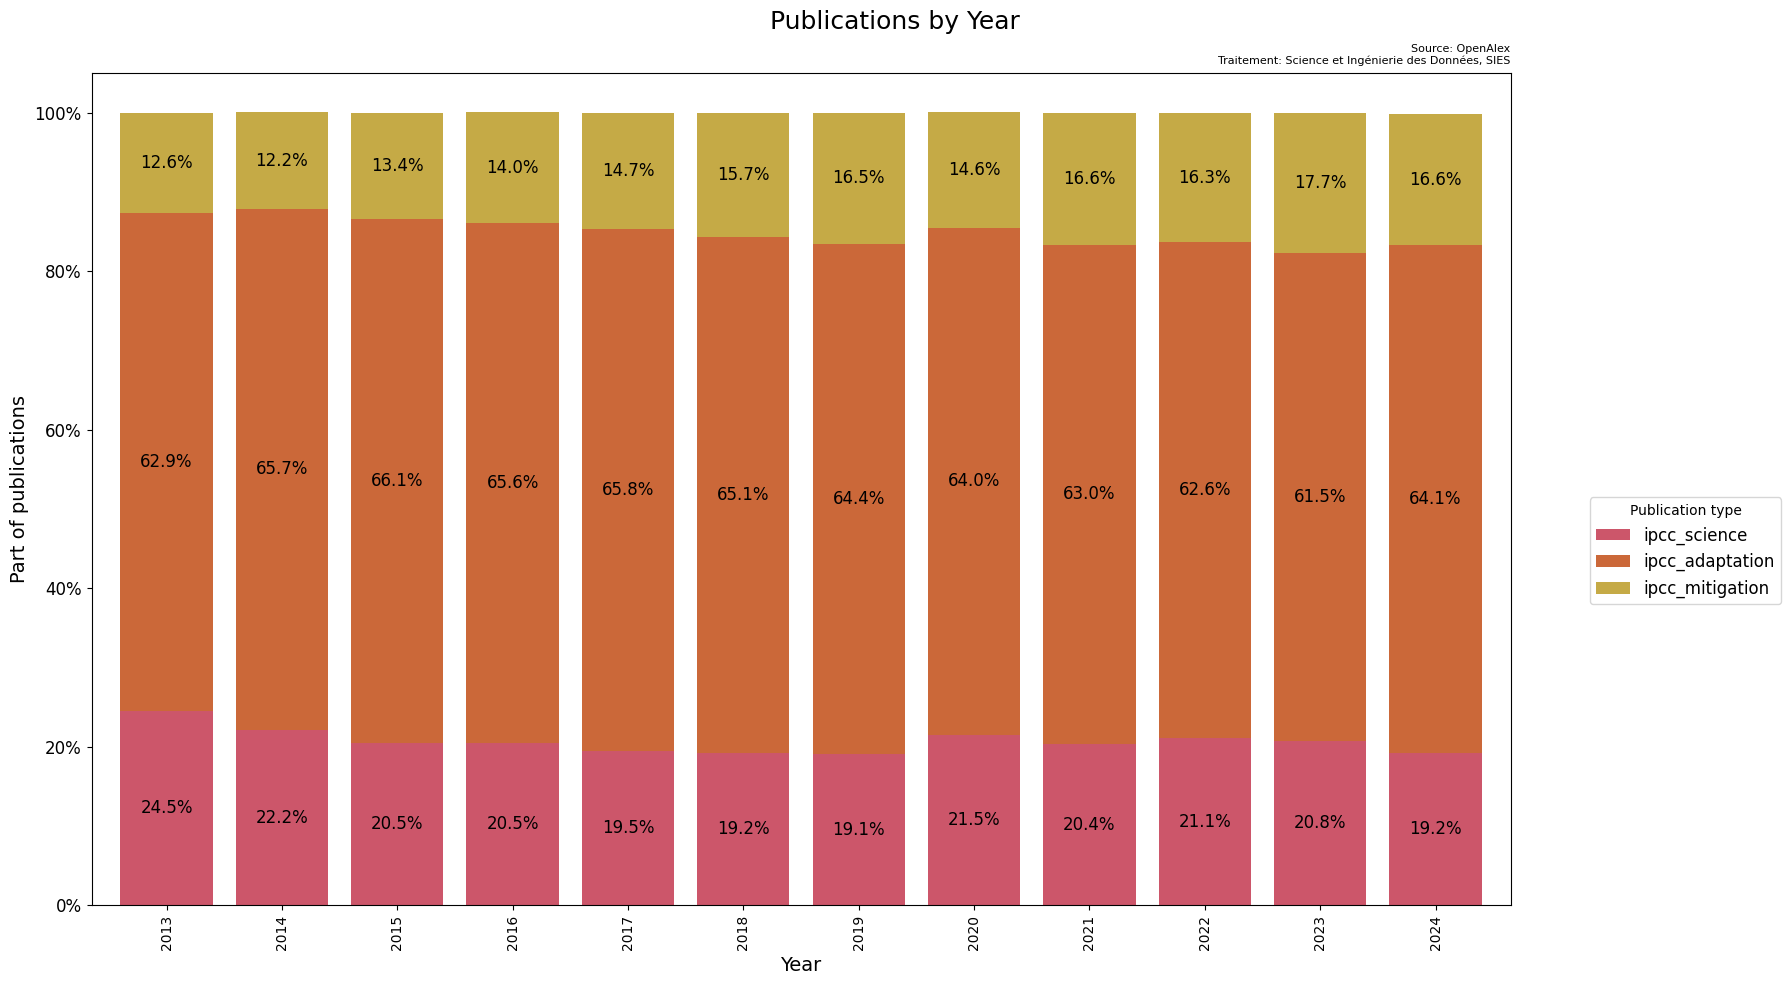

In [66]:
#avec topics
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "must": {
       "exists": {
         "field": "year"
       }
      }
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')
data_counts={}
for x in data['aggregations']['years']['buckets']:
    if x['doc_count']>=500 and x['key']>=2013:
      data_counts[x['key']]=[]
      tot=sum([i['doc_count'] for i in x['predicted_labels']['buckets'] if i['key'] in ['ipcc_science', 'ipcc_adaptation','ipcc_mitigation']])
      if 'ipcc_science' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_science'][0]
          data_counts[x['key']].append(round(nb*100/tot,1)) 
      else:
          data_counts[x['key']].append(0)
      if 'ipcc_adaptation' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_adaptation'][0]
          data_counts[x['key']].append(round(nb*100/tot,1)) 
      else:
          data_counts[x['key']].append(0)
      if 'ipcc_mitigation' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_mitigation'][0]
          data_counts[x['key']].append(round(nb*100/tot,1)) 
      else:
          data_counts[x['key']].append(0)
data_counts={key: value for key, value in data_counts.items() if value!= [0, 0, 0]}
df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['ipcc_science', 'ipcc_adaptation','ipcc_mitigation'])
df = df.sort_index()

list_colors=["#cc566a","#cb6839","#c5aa46","#747734","#62b055","#4bb2ac","#7377cc","#be5dae"]
ax = df.head(20).plot(kind='bar', stacked=True, figsize=(18, 10), width=0.8, color=list_colors)

for i, (index, row) in enumerate(df.head(20).iterrows()): 
    if row["ipcc_science"]!=0:
      ax.text(i, row['ipcc_science'] / 2, f'{row["ipcc_science"]}%', ha='center', va='center', color='black', size=12)
    if row["ipcc_adaptation"]!=0:
      ax.text(i, row['ipcc_science'] + row['ipcc_adaptation'] / 2, f'{row["ipcc_adaptation"]}%', ha='center', va='center', color='black', size=12)
    if row["ipcc_mitigation"]!=0:
      ax.text(i, row['ipcc_science'] + row['ipcc_adaptation'] + row['ipcc_mitigation']/ 2, f'{row["ipcc_mitigation"]}%', ha='center', va='center', color='black', size=12)

ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Part of publications', fontsize=14)
ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()], fontsize=12)

ax.legend(title='Publication type', bbox_to_anchor=(1.05, 0.5), loc='upper left', fontsize=12)

plt.suptitle("Publications by Year", size=18)
plt.title('Source: OpenAlex\nTraitement: Science et Ingénierie des Données, SIES', size=8, loc='right')

plt.tight_layout()
plt.show()

C:\Users\haallat\AppData\Local\Temp\ipykernel_23400\2238919108.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()], fontsize=12)


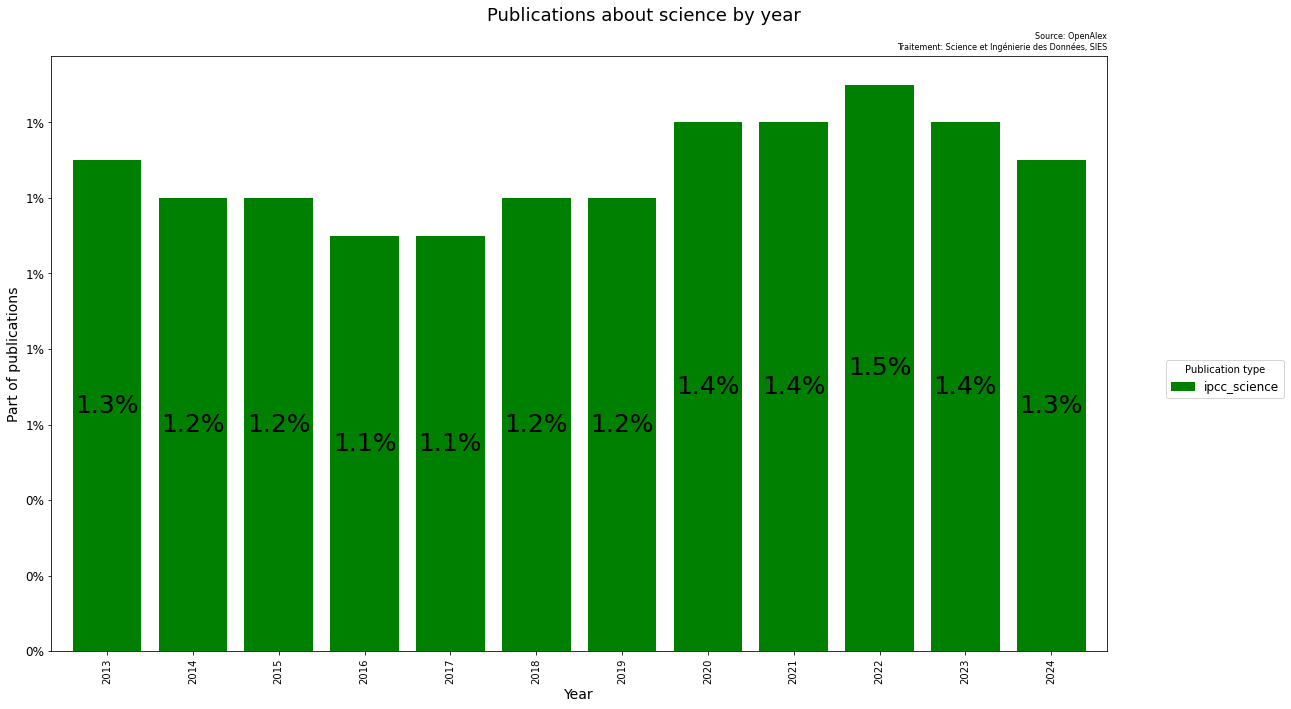

In [21]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "must": [
        {
          "term": {
            "externalIds.type": "hal"
          }
        }
       ]#,
      # "must_not": [
      #   {
      #     "term": {
      #       "externalIds.type": "doi"
      #     }
      #   }
      # ]
      ,
      "filter": {
       "exists": {
         "field": "topics"
       }
      }
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')

data_counts={}
for x in data['aggregations']['years']['buckets']:
    if x['doc_count']>=500 and x['key']>=2013:
      data_counts[x['key']]=[]
      if 'ipcc_science' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_science'][0]
          data_counts[x['key']].append(round(nb*100/x['doc_count'],1)) 
      else:
          data_counts[x['key']].append(0)
data_counts={key: value for key, value in data_counts.items() if value!= [0]}

df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['ipcc_science'])
df = df.sort_index()

ax = df.head(20).plot(kind='bar', stacked=True, figsize=(18, 10), width=0.8, color=['green'])

for i, (index, row) in enumerate(df.head(20).iterrows()): 
    ax.text(i, row['ipcc_science'] / 2, f'{row["ipcc_science"]}%', ha='center', va='center', color='black', size=25)
    #ax.text(i, row['not_ipcc'] + row['ipcc'] / 2, f'{row["ipcc"]}%', ha='center', va='center', color='black', size=12)

ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Part of publications', fontsize=14)
ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()], fontsize=12)

ax.legend(title='Publication type', bbox_to_anchor=(1.05, 0.5), loc='upper left', fontsize=12)

plt.suptitle("Publications about science by year", size=18)
plt.title('Source: OpenAlex\nTraitement: Science et Ingénierie des Données, SIES', size=8, loc='right')

plt.tight_layout()
plt.show()

top topics ipcc

In [123]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "exists": {
      "field": "topics"
    }
  },
  "aggs": {
    "predicted_labels": {
      "terms": {
        "field": "predict_teds.label.keyword",
        "size": 10000000
      },
      "aggs": {
        "topics": {
          "terms": {
            "field": "topics.display_name.keyword",
            "size": 15
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')

In [124]:
agg_ipcc=[bucket for bucket in data['aggregations']['predicted_labels']['buckets'] if bucket['key']=='ipcc'][0]

In [125]:
agg_ipcc['topics']['buckets']

[{'key': 'Climate Change and Variability Research', 'doc_count': 6357},
 {'key': 'Global Methane Emissions and Impacts', 'doc_count': 4645},
 {'key': 'Atmospheric Aerosols and their Impacts', 'doc_count': 4631},
 {'key': 'Climate Change and Paleoclimatology', 'doc_count': 4626},
 {'key': 'Impacts of Climate Change on Glaciers and Water Availability',
  'doc_count': 4220},
 {'key': 'Species Distribution Modeling and Climate Change Impacts',
  'doc_count': 4152},
 {'key': 'Global Forest Drought Response and Climate Change',
  'doc_count': 3778},
 {'key': 'Impacts of Climate Change on Marine Fisheries', 'doc_count': 3766},
 {'key': 'Stratospheric Chemistry and Climate Change Impacts',
  'doc_count': 3587},
 {'key': 'Resilience of Coral Reef Ecosystems to Climate Change',
  'doc_count': 3526},
 {'key': 'Marine Biogeochemistry and Ecosystem Dynamics', 'doc_count': 3359},
 {'key': 'Oceanic Modeling and Circulation Studies', 'doc_count': 3207},
 {'key': 'Numerical Weather Prediction Models', 